# Time Series Anomaly Detection in Mackey-Glass Time Series with TCN-AE

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/MarkusThill/bioma-tcn-ae/blob/main/src/main.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/MarkusThill/bioma-tcn-ae/blob/main/src/main.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

More details to come...

The following points should be considered:
- When using Google CoLab, remember to activate GPU accelaration: 
  - Navigate to Edit→Notebook Settings
  - select GPU from the Hardware Accelerator drop-down

In [1]:
#
# First Check, if we are running in Google CoLab
#
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
    print('Running on Google CoLab!')
else:
    print('Not running on Google CoLab!')

Not running on Google CoLab!


In [2]:
#
# Initially, install necessary packages and download the repository (required to access the data)
#
import os
if IN_COLAB:
    !pip3 install keras-tcn
    if not os.path.exists('/content/bioma-tcn-ae/'):
        print("Repo not cloned yet. Do it now!")
        !git clone https://github.com/MarkusThill/bioma-tcn-ae /content/bioma-tcn-ae/
    else:
        print("Repository already cloned!")

In [3]:
#
# In Google CoLab: Change the working directory to bioma-tcn-ae/src
#
if IN_COLAB and os.getcwd() != "/content/bioma-tcn-ae/src":
  # Print the current working directory
  print("Old working directory: {0}".format(os.getcwd()))

  # Change the current working directory
  os.chdir('/content/bioma-tcn-ae/src')

  # Print the current working directory
  print("New working directory: {0}".format(os.getcwd()))

In [4]:
#
# If this cell throws an error, make sure that you activated GPU acceleration, as described above!
#
if IN_COLAB:
    %tensorflow_version 2.x
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

In [5]:
import numpy
import time
from utilities import select_gpus, plot_results # utilities.py: Contains a few miscellaneous functions 
from tcnae import TCNAE # tcnae.py: Specification of the TCN-AE model
import data # data.py: Allows to generate anomalous Mackey-Glass (MG) time series 

# If you have several GPUs, select one or more here (in a list)
#select_gpus(0)

In [6]:
train_ts_id = 1 # [1-10]. Train the model on Mackey-Glass time series 1
data_gen = data.Data()
train_data = data_gen.build_data(train_ts_id, verbose = 0) # Returns a dictionary
train_X = train_data["train_X"] # We only need train_X (input = output) for the training process
print("train_X.shape:", train_X.shape) # A lot of training sequences of length 1050 and dimension 1

train_X.shape: (19791, 1050, 1)


In [7]:
#
# Build and compile the model
#
tcn_ae = TCNAE() # Use the parameters specified in the paper

#
# Train TCN-AE for 10 epochs. For a better accuracy 
# on the test case, increase the epochs to epochs=40 
# The training takes about 3-4 minutes for 10 epochs, 
# and 15 minutes for 40 epochs (on Google CoLab, with GPU enabled)
#
tcn_ae.fit(train_X, train_X, batch_size=32, epochs=10, verbose=1)

> Starting the Training...
Epoch 1/40
618/618 - 16s - loss: 0.0253 - logcosh: 0.0253 - val_loss: 0.0012 - val_logcosh: 0.0012
Epoch 2/40
618/618 - 15s - loss: 0.0011 - logcosh: 0.0011 - val_loss: 6.6988e-04 - val_logcosh: 6.6988e-04
Epoch 3/40
618/618 - 15s - loss: 7.2102e-04 - logcosh: 7.2102e-04 - val_loss: 5.2625e-04 - val_logcosh: 5.2625e-04
Epoch 4/40
618/618 - 15s - loss: 5.8016e-04 - logcosh: 5.8015e-04 - val_loss: 4.0497e-04 - val_logcosh: 4.0497e-04
Epoch 5/40
618/618 - 15s - loss: 5.0331e-04 - logcosh: 5.0331e-04 - val_loss: 4.4924e-04 - val_logcosh: 4.4924e-04
Epoch 6/40
618/618 - 15s - loss: 4.4031e-04 - logcosh: 4.4031e-04 - val_loss: 3.5117e-04 - val_logcosh: 3.5117e-04
Epoch 7/40
618/618 - 15s - loss: 4.1264e-04 - logcosh: 4.1264e-04 - val_loss: 3.1991e-04 - val_logcosh: 3.1991e-04
Epoch 8/40
618/618 - 15s - loss: 3.8277e-04 - logcosh: 3.8277e-04 - val_loss: 3.1657e-04 - val_logcosh: 3.1657e-04
Epoch 9/40
618/618 - 15s - loss: 3.6420e-04 - logcosh: 3.6420e-04 - val_loss:

In [8]:
#
# Test the model on another Mackey-Glass time series
# Might take a few minutes...
#
start_time = time.time()
test_ts_id = 3 # Test the model on Mackey-Glass time series 3
test_data = data_gen.build_data(test_ts_id, verbose = 0) # Returns a dictionary

#
# Take the whole time series... Like the training data, the test data is standardized (zero mean and unit variance)
#
test_X = test_data["scaled_series"].values[numpy.newaxis,:,:] # We need an extra dimension for the batch-dimension
print("test_X.shape", test_X.shape) # This is one long time series
anomaly_score = tcn_ae.predict(test_X)
print("> Time:", round(time.time() - start_time), "seconds.")

test_X.shape (1, 100000, 1)
> Time: 10 seconds.


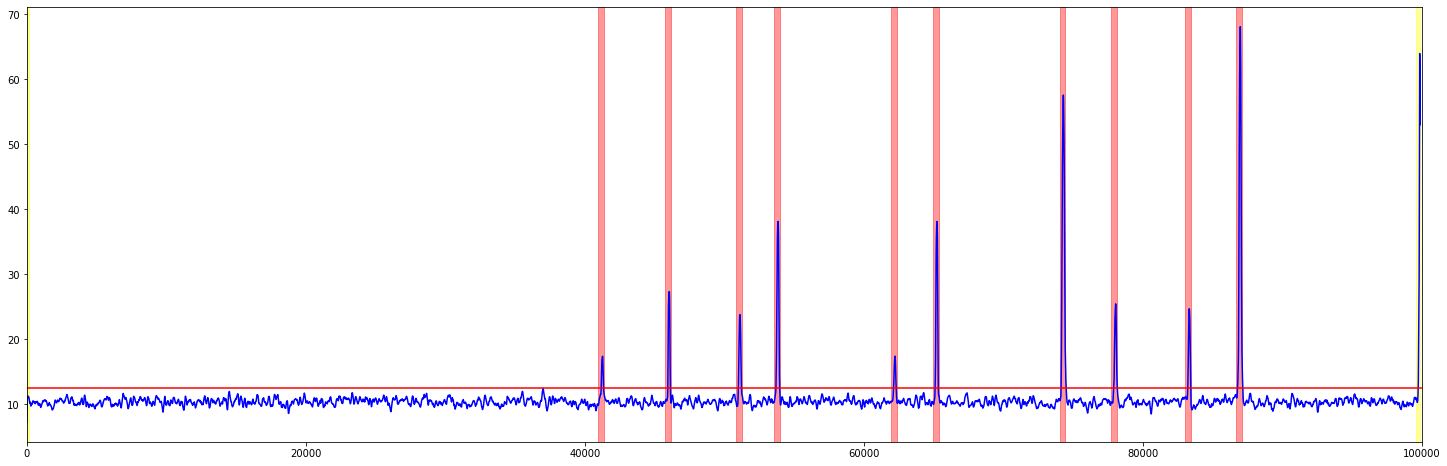

In [9]:
#
# Make a plot of the anomaly-score and see how it matches the real anomaly windows
# Vertical red bars show the actual anomalies.
# Vertical yellow bars show regions which can be ignored (usually start and 
# end of a time series, which lead to transient behavior for some algorithms).
# The blue curve is the anomaly score.
# The red horizontal line indicates a simple threshold, which is the smallest possible value that would not produce a false positive
#
plot_results(test_data, anomaly_score, pl_range = None, plot_signal = False, plot_anomaly_score = True)

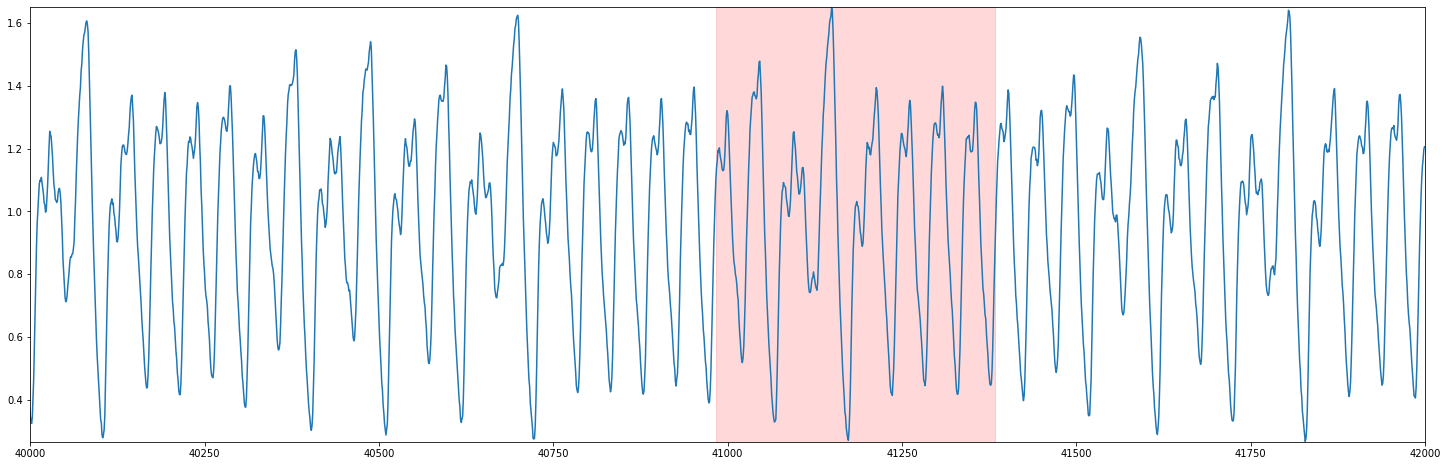

In [10]:
#
# Take a look at the MG time series: zoom into the first anomaly
#
plot_results(test_data, anomaly_score, pl_range = (40000, 42000), plot_signal = True, plot_anomaly_score = False)